In [1]:
'''Import all the necessary packages'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
import xgboost

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import pymongo

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# League of Legends Prediction Model

## Objective

- Predict the winner of a match at 15 minute mark
- Data that will be utilized include gold difference, xp difference, dragon difference, rift herald difference, inhibitor difference, cs difference, ward difference

## Assumptions and Data selection
Reference:  https://www.reddit.com/r/MachineLearning/comments/4vdsg4/predicting_the_winner_of_a_league_of_legends/

Based on the above work, the author was able to derive a model with 70% accuracy using about 85,000 League of Legends data from 10 minute mark. However, I believe the accuracy can be improved by analyzing the model at a later game time, 15 minutes, and focusing on player data at Diamond 1, Master and Challenger tiers.

The reasoning is that higher tier players are much more efficient at utilizing their leads and are less prone to trolling issues compared to players at lower tier. In fact, I believe the accuracy of the model will probably suffer greatly at lower tier because there will be significant amount of noise due to human factor - not utilizing leads properly, trolling, building wrong item paths etc.

## 1) What is League of Legends?

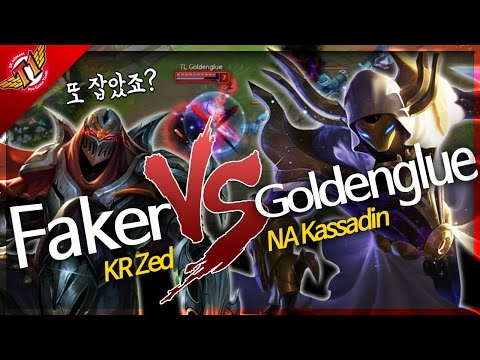

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('9w8a6uxDb2A')

### League of Legends Tier

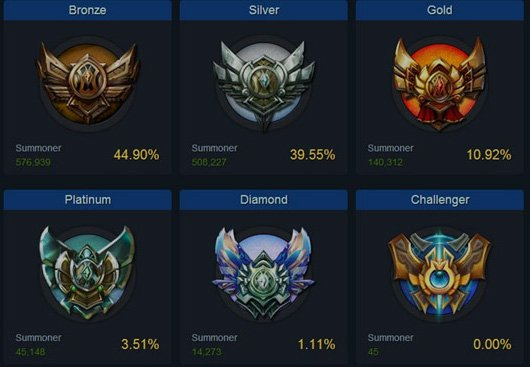

In [151]:
from IPython.display import Image
Image('league-of-legends-tiers-distribution.png')

## 2) Data Collection using Riot Open API

In [ ]:
def construct_matchId(playerName, game_general_compile = None, gameid_track = None, region = 'kr'):
    '''This method takes a playerName and extracts the general match history including
    the gameId, gameVersion, platFormId, queueId, seasonID for most recent 100 matches.
    
    Obviously, this function can be extended to collect more than 100 matches by including
    beginIndex and endIndex which will be done eventually.'''
    
    API_key = '<API_key here>'
    
    '''When collecting gameId using multiple players, I would like to keep using the already
    compiled list instead of creating a new one'''
    if game_general_compile == None:
        game_general_compile = []
        
    #Get the account ID to access match history
    '''I need the accountID, not regular id to get match history so let us do that first'''
    summoner = requests.get('https://' + region + '.api.riotgames.com/lol/summoner/v3/summoners/by-name/' + playerName + '?api_key=' + API_key)
    time.sleep(1.7)
    summoner = summoner.json()
    account = summoner['accountId']
    '''Since the rate limit is 100 requests every 120 seconds, need to give it
        at least 1.2 seconds between the every request'''
    
    for beginIndex in [0, 100, 200, 300, 400, 500]:  
        #This portion uses the account ID to access gameID/MatchId and compile a list
        #queue = 420 limits the search to 5 v 5 Ranked Solo Games
        history = requests.get('https://' + region +'.api.riotgames.com/lol/match/v3/matchlists/by-account/' + str(account) + '?queue=420&beginIndex=' + str(beginIndex) + '&api_key=' + str(API_key))
        #Actaully giving 1.2 seconds often causes an error, so I gave a safer margin of 3 seconds
        time.sleep(3)
        history = history.json()
        #In the history json, list of match history is stored under key 'matches'
        history_list = history['matches']
        
        '''This variable is used to keep track of gameid that is already included
        so that we can avoid crawling duplicates. This list is returned at the 
        end of the function call.'''
        if gameid_track == None:
            gameid_track = []
            
        gameid_compile = []
        for i in range(len(history_list)):
            gameid_compile.append(history_list[i]['gameId'])
        
        #game_general_compile is an empty list used to collect the sub-lists containing
        #relevant information for each match
        for i in range(len(gameid_compile)):
            print(beginIndex, ': ', i, ' : ', gameid_compile[i], playerName)
            '''In case a duplicate happens, just skip it'''
            if gameid_compile[i] in gameid_track:
                continue
            
            try:
                '''iterate through every gameId and extract relevant information such as gameVersion, platformId, queueId, and seasonId'''
                game1_detail = requests.get('https://' + region + '.api.riotgames.com/lol/match/v3/matches/' + str(gameid_compile[i]) + '?api_key=' + str(API_key))
                time.sleep(1.7)
                print(game1_detail)
                game1_detail = game1_detail.json()
            
                #Let us extract the game result, gameVersion, season, QueID
                #game1_general_info list contains the information of individual match and
                #this list is appended to the game_general_compile list.
                game1_general_info = []
                game1_version = game1_detail['gameVersion']
                game1_platformId = game1_detail['platformId']
                game1_queueId = game1_detail['queueId']
                game1_seasonId = game1_detail['seasonId'] 
                '''Append game info'''
                game1_general_info.append(gameid_compile[i])
                game1_general_info.append(game1_version)
                game1_general_info.append(game1_platformId)
                game1_general_info.append(game1_queueId)
                game1_general_info.append(game1_seasonId)
                '''The playerName is appended so I can track which player is the source
                of the corresponding gameId. This is for debugging purpose in case
                something funky happens'''
                game1_general_info.append(playerName)
                
                game_general_compile.append(game1_general_info)
                '''This track variable is used to avoid duplicate game data'''
                gameid_track.append(gameid_compile[i])
            except:
                print('Rate limit issue, continue onto next iteration')
                continue
            
    print('Player ', playerName, 'is done!')
    return game_general_compile, gameid_track

#Getting kr region matches
#Challenger League Seed
game_compile, gameid_track = construct_matchId('Hide on bush')
game_compile, gameid_track = construct_matchId('SKT T1 Effort', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('K T', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('SKT T1 Untara', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('DWG Nuguri', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('bbq Tempt', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('FeelsPepsiMan', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('ROX Lindarang', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Kingen', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('JAG S0hwan', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('SKT T1 Bang', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('DWG BeryL', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Longzhu Cuzz', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('PawN God', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Afreeca Kramer', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Afreeca Kuro', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Dutch Coffee', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Veritas522', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('JAG SnowFlower', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('MVP Max', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('GuGer', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('RRRuleRRR', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Greed A Pride', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('ROX Sangyoon', game_compile, gameid_track)

#Master League Seed
game_compile, gameid_track = construct_matchId('psh20', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('SKT T1 Huni', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Co1dplay', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('SKT T1 BIank', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('kfo', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('PuncHh', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Xero', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('SKT T1 WoIf', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('ZiviZiviZiviZ', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Cheers', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Reborn3', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('JAG UmTi', game_compile, gameid_track)

#Diamond 1 League Seed
game_compile, gameid_track = construct_matchId('zig zag n', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('KDM Edge', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('Mse corgi', game_compile, gameid_track)
game_compile, gameid_track = construct_matchId('YserAoA', game_compile, gameid_track)

In [ ]:
def get_general_matchinfo(gameId, time_analysis, match_detail_compile = None, except_list = None):
    '''This function is used to request and store important end game statistics.
    From end game open API information, we can extract the winner of the match,
    champions that were used by each team and who got first objectives'''
    gameId = str(gameId)
    API_key = '<API key here>'
    
    '''This list is the total compile list'''
    if match_detail_compile == None:
        match_detail_compile = []
        
    '''this list is used to store individual game information'''
    game_compile = []
    game_compile.append(gameId)
    
    '''In case a request rate limit error occurs, I would like the program to keep trying.
    But I also don't want the program to get stuck in a while loop. So I'll use trial_count 
    variable such that the program terminates after 10 tries and attach the failed gameId
    to except_list'''
    if except_list == None:
        except_list = []
    trial_count = 0
    while trial_count < 10:
        try:
            #################################################################################################
            '''First request the final match score information on Riot open API'''
            game1_final_history = requests.get('https://kr.api.riotgames.com/lol/match/v3/matches/' + gameId + '?api_key=' + API_key)
            game1_final_history = game1_final_history.json()
            time.sleep(1.7)
            
            '''Let us extract the winner of the match, champions that were used, and other useful
            information'''
            team_info = game1_final_history['teams']
            blue_side_info = team_info[0]
            red_side_info = team_info[1]
            
            blue_win = blue_side_info['win']
            blue_firsttower = blue_side_info['firstTower']
            blue_firstblood = blue_side_info['firstBlood']
            blue_firstherald = blue_side_info['firstRiftHerald']
            blue_firstinhibitor = blue_side_info['firstInhibitor']
            blue_firstdragon = blue_side_info['firstDragon']
            
            red_win = red_side_info['win']
            red_firsttower = red_side_info['firstTower']
            red_firstblood = red_side_info['firstBlood']
            red_firstherald = red_side_info['firstRiftHerald']
            red_firstinhibitor = red_side_info['firstInhibitor']
            red_firstdragon = red_side_info['firstDragon']
            
            '''compile above info'''
            game_compile.append(blue_win)
            game_compile.append(blue_firsttower)
            game_compile.append(blue_firstblood)
            game_compile.append(blue_firstherald)
            game_compile.append(blue_firstinhibitor)
            game_compile.append(blue_firstdragon)
            
            game_compile.append(red_win)
            game_compile.append(red_firsttower)
            game_compile.append(red_firstblood)
            game_compile.append(red_firstherald)
            game_compile.append(red_firstinhibitor)
            game_compile.append(red_firstdragon)
            
            '''From particpants information we can extract the champions that were used'''
            participant_info = game1_final_history['participants']
            
            '''Compile blue side champion list'''
            blue_side_champ_list = []
            for i in range(5):
                blue_side_champ_list.append(participant_info[i]['championId'])
                
            red_side_champ_list = []
            for i in range(5,10):
                red_side_champ_list.append(participant_info[i]['championId'])
            
            '''Compile champions individually'''
            for champion in blue_side_champ_list:
                game_compile.append(champion)
            for champion in red_side_champ_list:
                game_compile.append(champion)
            ######################################################################################    
            '''This portion grabs detailed chronological information of a given game.
            The timeanalysis input is used to specify the cut time for analysis. For instance,
            if timeanalysis = 15, that means the function will analyze the statistic of the
            game up to 15 mins'''    
            game1_history = requests.get('https://kr.api.riotgames.com/lol/match/v3/timelines/by-match/' + gameId + '?api_key=' + API_key)
            game1_history = game1_history.json()
            time.sleep(1.7)
            
            time_stamp_info = game1_history['frames'][time_analysis]
            participant_info = time_stamp_info['participantFrames']
            
            '''Blue side information compile'''
            blue_gold = 0
            blue_xp = 0
            blue_cs = 0
            for i in range(1, 6):
                i = str(i)
                blue_gold += participant_info[i]['totalGold']
                blue_xp += participant_info[i]['xp']
                blue_cs += participant_info[i]['minionsKilled']
                blue_cs += participant_info[i]['jungleMinionsKilled']
            
            '''Red side information compile'''
            red_gold = 0
            red_xp = 0
            red_cs = 0
            for j in range(6, 11):
                j = str(j)
                red_gold += participant_info[j]['totalGold']
                red_xp += participant_info[j]['xp']
                red_cs += participant_info[j]['minionsKilled']
                red_cs += participant_info[j]['jungleMinionsKilled']
            
            '''Compile the information'''
            game_compile.append(blue_gold)
            game_compile.append(blue_xp)
            game_compile.append(blue_cs)
            
            game_compile.append(red_gold)
            game_compile.append(red_xp)
            game_compile.append(red_cs)
            
            '''Now let us analyze events stored in the time_analysis'''
            blue_ward = 0
            blue_wardkill = 0
            blue_dragon = 0
            blue_herald = 0
            blue_championkill = 0
            blue_championassist = 0
            blue_tower = 0
            blue_inhibitor = 0
            blue_baron = 0
            
            red_ward = 0
            red_wardkill = 0
            red_dragon = 0
            red_herald = 0
            red_championkill = 0
            red_championassist = 0
            red_tower = 0
            red_inhibitor = 0
            red_baron = 0
            
            '''This index is used to keep track of the action
            taken by playerId'''
            blue_index = [1, 2, 3, 4, 5]
            red_index = [6, 7, 8, 9, 10, 0]
            
            for k in range(1, time_analysis + 1):
                time_frame_history = game1_history['frames'][k]['events']
                for z in range(len(time_frame_history)):
                    event_type = time_frame_history[z]['type']
                    # eventtypelist = {'postive_1': ['WARD_PLACED', 'WARD_KILL'], 'negative_1':[]}
                    #for evt in eventtypelist['positive_1]:
                    #
                    if event_type == 'WARD_PLACED' and time_frame_history[z]['wardType'] != 'UNDEFINED':
                        if time_frame_history[z]['creatorId'] in blue_index:
                            blue_ward += 1
                        elif time_frame_history[z]['creatorId'] in red_index:
                            red_ward += 1     
                    elif event_type == 'WARD_KILL':
                    #Track number of wards destroyed
                        if time_frame_history[z]['killerId'] in blue_index:
                            blue_wardkill += 1
                        elif time_frame_history[z]['killerId'] in red_index:
                            red_wardkill += 1              
                    elif event_type == 'CHAMPION_KILL':
                    #Keep track of champion kills and assists
                        if time_frame_history[z]['killerId'] in blue_index:
                            blue_championkill += 1
                            blue_championassist += len(time_frame_history[z]['assistingParticipantIds'])
                        elif time_frame_history[z]['killerId'] in red_index:
                            red_championkill += 1
                            red_championassist += len(time_frame_history[z]['assistingParticipantIds'])
                    elif event_type == 'BUILDING_KILL':
                    #Keep track of building kills which consist of mid, bot, top towers,
                    #inhibitors, nexus towers
                    #For some reason, if I use the same logic as above for first condition,
                    #the result doesn't match. So I used an alternative if condition to make
                    #sure the numbers are correct
                        if time_frame_history[z]['teamId'] == 200:
                            if time_frame_history[z]['buildingType'] == 'TOWER_BUILDING':
                                blue_tower += 1
                            elif time_frame_history[z]['buildingType'] == 'INHIBITOR_BUILDING':
                                blue_inhibitor += 1
                        elif time_frame_history[z]['teamId'] == 100:
                            if time_frame_history[z]['buildingType'] == 'TOWER_BUILDING':
                                red_tower += 1
                            elif time_frame_history[z]['buildingType'] == 'INHIBITOR_BUILDING':
                                red_inhibitor += 1
                    elif event_type == 'ELITE_MONSTER_KILL':
                    #Elite monsters include dragons, rift herald and baron
                        if time_frame_history[z]['killerId'] in blue_index:
                            if time_frame_history[z]['monsterType'] == 'RIFTHERALD':
                                blue_herald += 1
                            elif time_frame_history[z]['monsterType'] == 'BARON_NASHOR':
                                blue_baron += 1
                            elif time_frame_history[z]['monsterType'] == 'DRAGON':
                                blue_dragon += 1
                        elif time_frame_history[z]['killerId'] in red_index:
                            if time_frame_history[z]['monsterType'] == 'RIFTHERALD':
                                red_herald += 1
                            elif time_frame_history[z]['monsterType'] == 'BARON_NASHOR':
                                red_baron += 1
                            elif time_frame_history[z]['monsterType'] == 'DRAGON':
                                red_dragon += 1
            '''Of course compile all the game data as well'''
            game_compile.append(blue_ward)
            game_compile.append(blue_wardkill)
            game_compile.append(blue_dragon)
            game_compile.append(blue_herald)
            game_compile.append(blue_championkill)
            game_compile.append(blue_championassist)
            game_compile.append(blue_tower)
            game_compile.append(blue_inhibitor)
            game_compile.append(blue_baron)
            
            game_compile.append(red_ward)
            game_compile.append(red_wardkill)
            game_compile.append(red_dragon)
            game_compile.append(red_herald)
            game_compile.append(red_championkill)
            game_compile.append(red_championassist)
            game_compile.append(red_tower)
            game_compile.append(red_inhibitor)
            game_compile.append(red_baron)
            
            '''append the individual game information to the total compile list'''
            match_detail_compile.append(game_compile)
            '''Upon successful data acquisition, set the trial_count back to 0'''
            trial_count = 0
            print(gameId + ' analysis is complete!')
        except:
            print('Connection failed!')
            trial_count += 1
            if trial_count == 10:
                except_list.append(gameId)
            continue
        break
    
    return match_detail_compile, except_list

column_label = ['gameId', 'blue_win', 'blue_firsttower', 'blue_firstblood', 'blue_firstherald', 
                'blue_firstinhibitor', 'blue_firstdragon', 'red_win', 'red_firsttower',
                'red_firstblood', 'red_firstherald', 'red_firstinhibitor', 
                'red_firstdragon', 'blue_champ1', 'blue_champ2', 'blue_champ3',
                'blue_champ4', 'blue_champ5', 'red_champ1', 'red_champ2', 
                'red_champ3', 'red_champ4', 'red_champ5', 'blue_gold', 'blue_xp',
                'blue_cs', 'red_gold', 'red_xp', 'red_cs', 'blue_ward', 
                'blue_wardkill', 'blue_dragon', 'blue_herald', 'blue_championkill',
                'blue_championassist', 'blue_tower', 'blue_inhibitor', 'blue_baron',
                'red_ward', 'red_wardkill', 'red_dragon', 'red_herald',
                'red_championkill', 'red_championassist', 'red_tower', 'red_inhibitor',
                'red_baron']

'''Read the csv with compiled gameId'''
match_df = pd.read_csv('match_history.csv')
game_id = list(match_df['gameId'])

'''analyze one game outside the for loop to seed'''
match_detail_compile, except_list = get_general_matchinfo(game_id[0], 15)

'''Loop through the rest of indices using the initial seed data from above'''
for i in range(1, 17509):
    match_detail_compile, except_list = get_general_matchinfo(game_id[i], 15, 
                                                              match_detail_compile, except_list)
    
'''save the result in a csv file'''
match_detail_compile_df = pd.DataFrame(match_detail_compile, columns = column_label)
except_list_df = pd.DataFrame(except_list)

match_detail_compile_df.to_csv('match_detail_compile_0_175009.csv')
except_list_df.to_csv('except_list_0_175009.csv')

'''run except list again to extract info'''
except_list_total = pd.read_csv('except_list_total.csv')
except_list_total = list(except_list_total['exceptp_list'])

match_detail_compile, except_list = get_general_matchinfo(except_list_total[0], 15)
for i in range(1, 328):
    match_detail_compile, except_list = get_general_matchinfo(except_list_total, 15, match_detail_compile, except_list)
    
'''match history merge code'''

match_compile_total = pd.read_csv('match_detail_compile_total.csv')
match_history_df = pd.read_csv('match_history.csv')

match_history_df.drop(match_history_df.columns[[0]], axis = 1, inplace = True)

merge_result = match_compile_total.merge(match_history_df, how = "left")
merge_result.to_csv('merge_result.csv')

In [5]:
def transform_data(merge_result):
    '''This function takes the raw data generated using Riot API and cleans
    up the data such that it can be fed into a ML algorithm. The perspective
    of the data is with respect to the blue side. For instance, positive
    gold difference indicates that blue side had that much gold lead, and
    vice versa.'''
    cleanse_df = pd.DataFrame() 
    cleanse_df['gameId'] = merge_result['gameId']
    
    '''This is our predictor value'''
    cleanse_df['blue_win'] = merge_result['blue_win']
    
    '''All the features'''
    cleanse_df['gold_difference'] = merge_result['blue_gold'] - merge_result['red_gold']
    cleanse_df['xp_difference'] = merge_result['blue_xp'] - merge_result['red_xp']
    cleanse_df['cs_difference'] = merge_result['blue_cs'] - merge_result['red_cs']
    cleanse_df['ward_difference'] = merge_result['blue_ward'] - merge_result['red_ward']
    cleanse_df['wardkill_difference'] = merge_result['blue_wardkill'] - merge_result['red_wardkill']
    cleanse_df['dragon_difference'] = merge_result['blue_dragon'] - merge_result['red_dragon']
    cleanse_df['herald_difference'] = merge_result['blue_herald'] - merge_result['red_herald']
    cleanse_df['championkill_difference'] = merge_result['blue_championkill'] - merge_result['red_championkill']
    cleanse_df['championassist_difference'] = merge_result['blue_championassist'] - merge_result['red_championassist']
    cleanse_df['tower_difference'] = merge_result['blue_tower'] - merge_result['red_tower']
    cleanse_df['inhibitor_difference'] = merge_result['blue_inhibitor'] - merge_result['red_inhibitor']
    
    '''Some internal game info that is useful to keep track of'''
    cleanse_df['gameVersion'] = merge_result['gameVersion']
    cleanse_df['region'] = merge_result['region']
    cleanse_df['queueId'] = merge_result['queueId']
    cleanse_df['season'] = merge_result['season']
    
    return cleanse_df

In [6]:
merge_result = pd.read_csv('merge_result.csv')
merge_result.head(10)

gameId blue_win  blue_firsttower  blue_firstblood  blue_firstherald  \
0  3030211588      Win             True            False             False   
1  3030197041      Win             True             True              True   
2  3028401792     Fail             True            False             False   
3  3028349193     Fail            False             True             False   
4  3028345928      Win             True            False             False   
5  3028331253      Win             True            False             False   
6  3028307584      Win             True             True              True   
7  3027844628     Fail            False             True             False   
8  3027742337     Fail            False             True              True   
9  3027678846     Fail             True             True             False   

   blue_firstinhibitor  blue_firstdragon red_win  red_firsttower  \
0                 True              True    Fail           False   
1                 True             False    Fail           False   
2                False              True     Win           False   
3                False             False     Win            True   
4                 True              True    Fail           False   
5                 True             False    Fail           False   
6                False              True    Fail           False   
7                False             False     Win            True   
8                False             False     Win            True   
9                False             False     Win           False   

   red_firstblood      ...       red_championkill  red_championassist  \
0            True      ...                     12                  11   
1           False      ...                      6                   4   
2            True      ...                     20                  25   
3           False      ...                     17                  22   
4            True      ...                     15                  23   
5            True      ...                      6                   9   
6           False      ...                      4                   4   
7           False      ...                     11                  14   
8           False      ...                     10                  16   
9           False      ...                      9                   9   

   red_tower  red_inhibitor  red_baron    gameVersion  region  queueId  \
0          0              0          0  7.23.209.7302      KR      420   
1          1              0          0  7.23.209.7302      KR      420   
2          1              0          0  7.23.209.7302      KR      420   
3          3              0          0  7.23.209.7302      KR      420   
4          1              0          0  7.23.209.7302      KR      420   
5          1              0          0  7.23.209.7302      KR      420   
6          0              0          0  7.23.209.7302      KR      420   
7          1              0          0  7.23.209.7302      KR      420   
8          1              0          0  7.23.209.7302      KR      420   
9          0              0          0  7.23.209.7302      KR      420   

   season   seed_player  
0       9  Hide on bush  
1       9  Hide on bush  
2       9  Hide on bush  
3       9  Hide on bush  
4       9  Hide on bush  
5       9  Hide on bush  
6       9  Hide on bush  
7       9  Hide on bush  
8       9  Hide on bush  
9       9  Hide on bush  

[10 rows x 52 columns]

In [7]:
cleanse_df = transform_data(merge_result)
cleanse_df.head(10)

gameId blue_win  gold_difference  xp_difference  cs_difference  \
0  3030211588      Win             7297           4029             44   
1  3030197041      Win             1610          -1685            -46   
2  3028401792     Fail            -4057          -3256             38   
3  3028349193     Fail            -6645          -5184             18   
4  3028345928      Win             -513            584             79   
5  3028331253      Win             1941            674             37   
6  3028307584      Win             8420           3931             44   
7  3027844628     Fail            -2771          -2581            -15   
8  3027742337     Fail            -1248           -606            -23   
9  3027678846     Fail            -1291          -3327            -33   

   ward_difference  wardkill_difference  dragon_difference  herald_difference  \
0                3                  -11                  1                  0   
1               16                  -16                 -2                  1   
2               -4                    1                  1                  0   
3                2                  -24                  0                  0   
4                5                    5                  0                  0   
5               -2                  -11                  0                 -1   
6                9                    3                  1                  0   
7                0                   -8                  0                  0   
8               -2                    2                  0                  0   
9               -3                    4                 -1                  0   

   championkill_difference  championassist_difference  tower_difference  \
0                        3                          3                 3   
1                        1                          6                 1   
2                      -14                        -18                 0   
3                      -10                        -10                -3   
4                        0                        -13                 0   
5                        0                         -1                 1   
6                       10                         18                 4   
7                       -5                         -6                -1   
8                        3                          2                 0   
9                       -4                         -1                 1   

   inhibitor_difference    gameVersion region  queueId  season  
0                     0  7.23.209.7302     KR      420       9  
1                     0  7.23.209.7302     KR      420       9  
2                     0  7.23.209.7302     KR      420       9  
3                     0  7.23.209.7302     KR      420       9  
4                     0  7.23.209.7302     KR      420       9  
5                     0  7.23.209.7302     KR      420       9  
6                     0  7.23.209.7302     KR      420       9  
7                     0  7.23.209.7302     KR      420       9  
8                     0  7.23.209.7302     KR      420       9  
9                     0  7.23.209.7302     KR      420       9

In [8]:
cleanse_df.tail(10)

gameId blue_win  gold_difference  xp_difference  cs_difference  \
17166  3001450426      Win             8150           7631             48   
17167  3001365539      Win             1380           -792            -35   
17168  3001358783      Win             4883           3113             76   
17169  3001351966      Win            10698           7239            111   
17170  3001232447      Win              738            306            -22   
17171  3001015773      Win             4407           2331             -1   
17172  3000887545      Win             -308           -115             12   
17173  3000623413      Win             2276            765              6   
17174  3000640942      Win             4076           1507             -6   
17175  3000598278     Fail            -3769          -1526            -38   

       ward_difference  wardkill_difference  dragon_difference  \
17166                1                   -1                  1   
17167                3                    4                 -1   
17168               10                    0                  1   
17169                0                    6                  1   
17170                6                    3                  0   
17171                3                   -3                  0   
17172               -5                    4                  0   
17173                0                    2                  1   
17174                2                    1                  0   
17175               10                    0                 -1   

       herald_difference  championkill_difference  championassist_difference  \
17166                  0                       11                          6   
17167                  0                        3                          5   
17168                  0                        7                         13   
17169                  1                       11                         10   
17170                  0                        3                          7   
17171                  1                        2                         -1   
17172                  0                       -2                         -5   
17173                  0                        1                          5   
17174                  0                        2                          2   
17175                  0                       -1                          0   

       tower_difference  inhibitor_difference    gameVersion region  queueId  \
17166                 2                     0  7.21.206.6866     KR      420   
17167                 1                     0  7.21.206.6866     KR      420   
17168                 1                     0  7.21.206.6866     KR      420   
17169                 3                     0  7.21.206.6866     KR      420   
17170                 0                     0  7.21.206.6866     KR      420   
17171                 4                     0  7.21.206.6866     KR      420   
17172                 0                     0  7.21.206.6866     KR      420   
17173                 1                     0  7.21.206.6866     KR      420   
17174                 3                     0  7.21.206.6866     KR      420   
17175                -2                     0  7.21.206.6866     KR      420   

       season  
17166       9  
17167       9  
17168       9  
17169       9  
17170       9  
17171       9  
17172       9  
17173       9  
17174       9  
17175       9

In [9]:
cleanse_df.shape

(17176, 17)

### Check there are no NaN values and that gameId values are unique

In [10]:
#Check for NaN values
cleanse_df.isnull().sum()

gameId                       0
blue_win                     0
gold_difference              0
xp_difference                0
cs_difference                0
ward_difference              0
wardkill_difference          0
dragon_difference            0
herald_difference            0
championkill_difference      0
championassist_difference    0
tower_difference             0
inhibitor_difference         0
gameVersion                  0
region                       0
queueId                      0
season                       0
dtype: int64

### Check whether all gameId values are unique

In [11]:
#This code checks whether all gameId are unique. This is obviously to make
#sure we don't have duplicate data
gameId_series = cleanse_df['gameId']
print(len(gameId_series.unique()))

17175


### minimum and maximum gold and xp difference

In [12]:
gold_list = cleanse_df['gold_difference']
xp_list = cleanse_df['xp_difference']

In [13]:
gold_list.max()

21126

In [14]:
gold_list.min()

-19846

In [15]:
xp_list.max()

18278

In [16]:
xp_list.min()

-14710

### Classify gold and xp into range units

For easier visualization, I'll create new columns that divides the gold difference and xp difference by 1000 units.

In [17]:
def gold_xp_divider(difference_list):
    difference_compile = []
    for item in difference_list:
        #Positive difference portion
        if item >= 0 and item < 1000:
            difference_compile.append('0')
        elif item >= 1000 and item < 2000:
            difference_compile.append('1000')
        elif item >= 2000 and item < 3000:
            difference_compile.append('2000')
        elif item >= 3000 and item < 4000:
            difference_compile.append('3000')
        elif item >= 4000 and item < 5000:
            difference_compile.append('4000')
        elif item >= 5000 and item < 6000:
            difference_compile.append('5000')
        elif item >= 6000 and item < 7000:
            difference_compile.append('6000')
        elif item >= 7000 and item < 8000:
            difference_compile.append('7000')
        elif item >= 8000 and item < 9000:
            difference_compile.append('8000')
        elif item >= 9000 and item < 10000:
            difference_compile.append('9000')
        elif item >= 10000:
            difference_compile.append('10000')
        #Negative difference portion
        if item < 0 and item > -1000:
            difference_compile.append('-0')
        elif item <= -1000 and item > -2000:
            difference_compile.append('-1000')
        elif item <= -2000 and item > -3000:
            difference_compile.append('-2000')
        elif item <= -3000 and item > -4000:
            difference_compile.append('-3000')
        elif item <= -4000 and item > -5000:
            difference_compile.append('-4000')
        elif item <= -5000 and item > -6000:
            difference_compile.append('-5000')
        elif item <= -6000 and item > -7000:
            difference_compile.append('-6000')
        elif item <= -7000 and item > -8000:
            difference_compile.append('-7000')
        elif item <= -8000 and item > -9000:
            difference_compile.append('-8000')
        elif item <= -9000 and item > -10000:
            difference_compile.append('-9000')
        elif item <= -10000:
            difference_compile.append('-10000')
    return difference_compile

In [18]:
'''Generate lists that contains the range information for gold and xp'''
gold_divided = gold_xp_divider(gold_list)
xp_divided = gold_xp_divider(xp_list)

In [19]:
#Add above lists to the dataframe
cleanse_df['gold_divided'] = gold_divided
cleanse_df['xp_divided'] = xp_divided

In [20]:
cleanse_df.head(10)

gameId blue_win  gold_difference  xp_difference  cs_difference  \
0  3030211588      Win             7297           4029             44   
1  3030197041      Win             1610          -1685            -46   
2  3028401792     Fail            -4057          -3256             38   
3  3028349193     Fail            -6645          -5184             18   
4  3028345928      Win             -513            584             79   
5  3028331253      Win             1941            674             37   
6  3028307584      Win             8420           3931             44   
7  3027844628     Fail            -2771          -2581            -15   
8  3027742337     Fail            -1248           -606            -23   
9  3027678846     Fail            -1291          -3327            -33   

   ward_difference  wardkill_difference  dragon_difference  herald_difference  \
0                3                  -11                  1                  0   
1               16                  -16                 -2                  1   
2               -4                    1                  1                  0   
3                2                  -24                  0                  0   
4                5                    5                  0                  0   
5               -2                  -11                  0                 -1   
6                9                    3                  1                  0   
7                0                   -8                  0                  0   
8               -2                    2                  0                  0   
9               -3                    4                 -1                  0   

   championkill_difference  championassist_difference  tower_difference  \
0                        3                          3                 3   
1                        1                          6                 1   
2                      -14                        -18                 0   
3                      -10                        -10                -3   
4                        0                        -13                 0   
5                        0                         -1                 1   
6                       10                         18                 4   
7                       -5                         -6                -1   
8                        3                          2                 0   
9                       -4                         -1                 1   

   inhibitor_difference    gameVersion region  queueId  season gold_divided  \
0                     0  7.23.209.7302     KR      420       9         7000   
1                     0  7.23.209.7302     KR      420       9         1000   
2                     0  7.23.209.7302     KR      420       9        -4000   
3                     0  7.23.209.7302     KR      420       9        -6000   
4                     0  7.23.209.7302     KR      420       9           -0   
5                     0  7.23.209.7302     KR      420       9         1000   
6                     0  7.23.209.7302     KR      420       9         8000   
7                     0  7.23.209.7302     KR      420       9        -2000   
8                     0  7.23.209.7302     KR      420       9        -1000   
9                     0  7.23.209.7302     KR      420       9        -1000   

  xp_divided  
0       4000  
1      -1000  
2      -3000  
3      -5000  
4          0  
5          0  
6       3000  
7      -2000  
8         -0  
9      -3000

In [21]:
cleanse_df.tail(10)

gameId blue_win  gold_difference  xp_difference  cs_difference  \
17166  3001450426      Win             8150           7631             48   
17167  3001365539      Win             1380           -792            -35   
17168  3001358783      Win             4883           3113             76   
17169  3001351966      Win            10698           7239            111   
17170  3001232447      Win              738            306            -22   
17171  3001015773      Win             4407           2331             -1   
17172  3000887545      Win             -308           -115             12   
17173  3000623413      Win             2276            765              6   
17174  3000640942      Win             4076           1507             -6   
17175  3000598278     Fail            -3769          -1526            -38   

       ward_difference  wardkill_difference  dragon_difference  \
17166                1                   -1                  1   
17167                3                    4                 -1   
17168               10                    0                  1   
17169                0                    6                  1   
17170                6                    3                  0   
17171                3                   -3                  0   
17172               -5                    4                  0   
17173                0                    2                  1   
17174                2                    1                  0   
17175               10                    0                 -1   

       herald_difference  championkill_difference  championassist_difference  \
17166                  0                       11                          6   
17167                  0                        3                          5   
17168                  0                        7                         13   
17169                  1                       11                         10   
17170                  0                        3                          7   
17171                  1                        2                         -1   
17172                  0                       -2                         -5   
17173                  0                        1                          5   
17174                  0                        2                          2   
17175                  0                       -1                          0   

       tower_difference  inhibitor_difference    gameVersion region  queueId  \
17166                 2                     0  7.21.206.6866     KR      420   
17167                 1                     0  7.21.206.6866     KR      420   
17168                 1                     0  7.21.206.6866     KR      420   
17169                 3                     0  7.21.206.6866     KR      420   
17170                 0                     0  7.21.206.6866     KR      420   
17171                 4                     0  7.21.206.6866     KR      420   
17172                 0                     0  7.21.206.6866     KR      420   
17173                 1                     0  7.21.206.6866     KR      420   
17174                 3                     0  7.21.206.6866     KR      420   
17175                -2                     0  7.21.206.6866     KR      420   

       season gold_divided xp_divided  
17166       9         8000       7000  
17167       9         1000         -0  
17168       9         4000       3000  
17169       9        10000       7000  
17170       9            0          0  
17171       9         4000       2000  
17172       9           -0         -0  
17173       9         2000          0  
17174       9         4000       1000  
17175       9        -3000      -1000

## 3) MongoDB collection and EDA using MongoDB commands

In [22]:
#Connec to AWS EC2 server MongoDB
username = 'username'
password = 'passowrd'
connection = pymongo.MongoClient('mongodb://%s:%s@52.78.226.78' % (username, password))

In [23]:
#This makes connection to a new collection named leagueoflegend
db = connection.leagueoflegend

In [24]:
print(db)

Database(MongoClient(host=['52.78.226.78:27017'], document_class=dict, tz_aware=False, connect=True), 'leagueoflegend')


In [25]:
league_collection = db.leagueoflegend

In [26]:
#We'll be using to_dict with input orient = records to convert the dataFrame
#into a dictionary form that can be inserted to MongoDB
test = cleanse_df.iloc[:2, :]
test_dict = test.to_dict(orient = 'records')
print(test_dict)

[{'gameId': 3030211588, 'blue_win': 'Win', 'gold_difference': 7297, 'xp_difference': 4029, 'cs_difference': 44, 'ward_difference': 3, 'wardkill_difference': -11, 'dragon_difference': 1, 'herald_difference': 0, 'championkill_difference': 3, 'championassist_difference': 3, 'tower_difference': 3, 'inhibitor_difference': 0, 'gameVersion': '7.23.209.7302', 'region': 'KR', 'queueId': 420, 'season': 9, 'gold_divided': '7000', 'xp_divided': '4000'}, {'gameId': 3030197041, 'blue_win': 'Win', 'gold_difference': 1610, 'xp_difference': -1685, 'cs_difference': -46, 'ward_difference': 16, 'wardkill_difference': -16, 'dragon_difference': -2, 'herald_difference': 1, 'championkill_difference': 1, 'championassist_difference': 6, 'tower_difference': 1, 'inhibitor_difference': 0, 'gameVersion': '7.23.209.7302', 'region': 'KR', 'queueId': 420, 'season': 9, 'gold_divided': '1000', 'xp_divided': '-1000'}]


In [72]:
#This isn't the most elegant way to perform this, but using to_dict to the
#entire dataFrame caused some memory issues, so I just updated one by one.
for i in range(17177):
    try:
        temp = cleanse_df.iloc[i:i + 1, :]
        temp_dict = temp.to_dict(orient = 'records')
        league_collection.insert_many(temp_dict)
    except:
        break

In [27]:
#First count to make sure all data are properly saved in MongoDB
total_count = league_collection.count()
total_count

17176

In [28]:
#Let us see how the data is structured within MongoDB
for information in league_collection.find().limit(3):
    print(information)

{'_id': ObjectId('5a317f27922c510358417bda'), 'gameId': 3030211588, 'blue_win': 'Win', 'gold_difference': 7297, 'xp_difference': 4029, 'cs_difference': 44, 'ward_difference': 3, 'wardkill_difference': -11, 'dragon_difference': 1, 'herald_difference': 0, 'championkill_difference': 3, 'championassist_difference': 3, 'tower_difference': 3, 'inhibitor_difference': 0, 'gameVersion': '7.23.209.7302', 'region': 'KR', 'queueId': 420, 'season': 9, 'gold_divided': '7000', 'xp_divided': '4000'}
{'_id': ObjectId('5a317f27922c510358417bdb'), 'gameId': 3030197041, 'blue_win': 'Win', 'gold_difference': 1610, 'xp_difference': -1685, 'cs_difference': -46, 'ward_difference': 16, 'wardkill_difference': -16, 'dragon_difference': -2, 'herald_difference': 1, 'championkill_difference': 1, 'championassist_difference': 6, 'tower_difference': 1, 'inhibitor_difference': 0, 'gameVersion': '7.23.209.7302', 'region': 'KR', 'queueId': 420, 'season': 9, 'gold_divided': '1000', 'xp_divided': '-1000'}
{'_id': ObjectId(

### Check the percentage for blue win -> this should roughly be around 50% although it might be a little higher for the blue due to map bias

In [29]:
blue_win_count = league_collection.count({'blue_win' : 'Win'})
print(blue_win_count)
print('Blue side won {}% of the game'.format((blue_win_count / total_count) * 100))

8917
Blue side won 51.91546343735445% of the game


#### As you can see, blue side has slightly higher winning chance of 52%. But, Riot admitted that this is mainly due to ban/pick order and the inherent bias in how the map is designed

### Let us check the rough distribution of gold difference by 1000 unit

In [30]:
count_compile = []

In [31]:
count_0 = league_collection.count({'gold_divided' : '0'})
count_0_m = league_collection.count({'gold_divided': '-0'}) 
count_0_total = count_0 + count_0_m
count_compile.append(count_0_total)
print(count_0, count_0_m)

1416 1454


In [32]:
count_1000 = league_collection.count({'gold_divided' : '1000'})
count_1000_m = league_collection.count({'gold_divided' : '-1000'})
count_1000_total = count_1000 + count_1000_m
count_compile.append(count_1000_total)
print(count_1000, count_1000_m)

1443 1329


In [33]:
count_2000 = league_collection.count({'gold_divided' : '2000'})
count_2000_m = league_collection.count({'gold_divided' : '-2000'})
count_2000_total = count_2000 + count_2000_m
count_compile.append(count_2000_total)
print(count_2000, count_2000_m)

1275 1189


In [34]:
count_3000 = league_collection.count({'gold_divided' : '3000'})
count_3000_m = league_collection.count({'gold_divided' : '-3000'})
count_3000_total = count_3000 + count_3000_m
count_compile.append(count_3000_total)
print(count_3000, count_3000_m)

1118 1052


In [35]:
count_4000 = league_collection.count({'gold_divided' : '4000'})
count_4000_m = league_collection.count({'gold_divided' : '-4000'})
count_4000_total = count_4000 + count_4000_m
count_compile.append(count_4000_total)
print(count_4000, count_4000_m)

956 891


In [36]:
count_5000 = league_collection.count({'gold_divided' : '5000'})
count_5000_m = league_collection.count({'gold_divided' : '-5000'})
count_5000_total = count_5000 + count_5000_m
count_compile.append(count_5000_total)
print(count_5000, count_5000_m)

769 673


In [37]:
count_6000 = league_collection.count({'gold_divided' : '6000'})
count_6000_m = league_collection.count({'gold_divided' : '-6000'})
count_6000_total = count_6000 + count_6000_m
count_compile.append(count_6000_total)
print(count_6000, count_6000_m)

557 490


In [38]:
count_7000 = league_collection.count({'gold_divided' : '7000'})
count_7000_m = league_collection.count({'gold_divided' : '-7000'})
count_7000_total = count_7000 + count_7000_m
count_compile.append(count_7000_total)
print(count_7000, count_7000_m)

439 362


In [39]:
count_8000 = league_collection.count({'gold_divided' : '8000'})
count_8000_m = league_collection.count({'gold_divided' : '-8000'})
count_8000_total = count_8000 + count_8000_m
count_compile.append(count_8000_total)
print(count_8000, count_8000_m)

299 250


In [40]:
count_9000 = league_collection.count({'gold_divided' : '9000'})
count_9000_m = league_collection.count({'gold_divided' : '-9000'})
count_9000_total = count_9000 + count_9000_m
count_compile.append(count_9000_total)
print(count_9000, count_9000_m)

222 195


In [41]:
count_10000 = league_collection.count({'gold_divided' : '10000'})
count_10000_m = league_collection.count({'gold_divided' : '-10000'})
count_10000_total = count_10000 + count_10000_m
count_compile.append(count_10000_total)
print(count_10000, count_10000_m)

436 361


In [42]:
print(count_compile)

[2870, 2772, 2464, 2170, 1847, 1442, 1047, 801, 549, 417, 797]


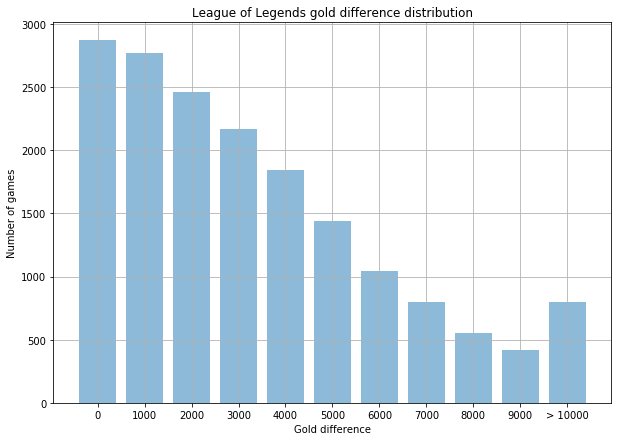

In [43]:
plt.figure(figsize = (10, 7))
plt.bar(['0', '1000', '2000', '3000', '4000', '5000', '6000', '7000', '8000', '9000', '> 10000'], count_compile, align='center', alpha=0.5)
plt.title('League of Legends gold difference distribution')
plt.ylabel('Number of games')
plt.xlabel('Gold difference')
plt.grid(True)
plt.show()

### Make sure all matches are from solo ranked games -> All 17176 data should correspond to ranked solo matches since the Open API calls were based on ranked solo queue matches

In [44]:
league_collection.count({'queueId' : 420})

17176

### Count number of games where inhibitors were taken -> There shouldn't be that many since it is pretty rare to push an inhibitor at 15 min mark.

In [45]:
league_collection.count({'inhibitor_difference' : {'$ne' : 0}})

355

### Count number of games where rift herald is taken

In [46]:
league_collection.count({'herald_difference' : {'$ne' : 0}})

3654

## 4) EDA Visualization

### Now that we have done some basic EDA using MongoDB, we'll utilize the Seaborn library this time for easier visualization.

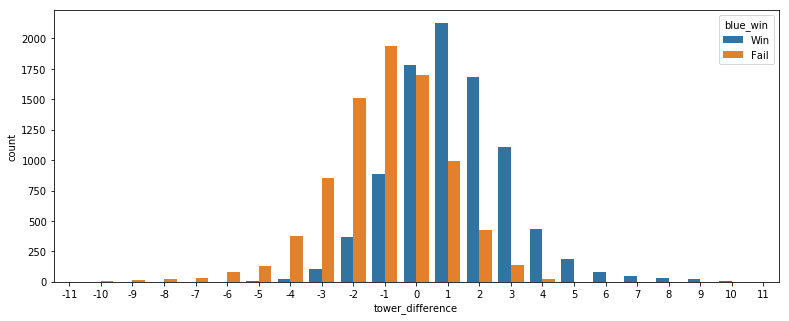

In [47]:
#Let us analyze how the tower difference affects the outcome
plt.figure(figsize = (13, 5))
sns.countplot(x = 'tower_difference', hue = 'blue_win', data = cleanse_df)
plt.show()

#### Even an advantage of 1 tower has a pretty significant effect on the win/loss at 15 minute mark

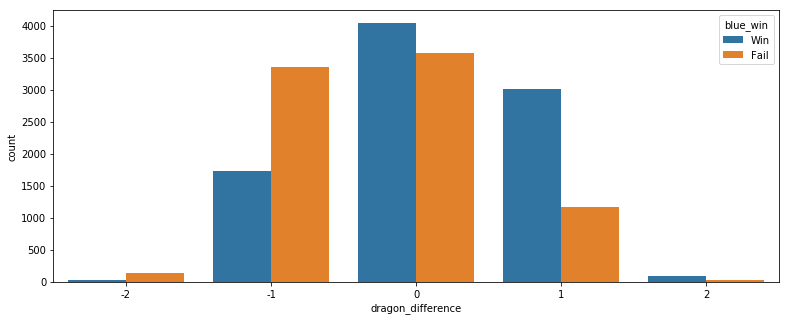

In [48]:
#Let us analyze how the dragon difference affects the outcome
plt.figure(figsize = (13, 5))
sns.countplot(x = 'dragon_difference', hue = 'blue_win', data = cleanse_df)
plt.show()

#### For most games, the difference in number of dragons was within 2 and just as with tower differences, having one dragon indicated a significant increase in winning rate

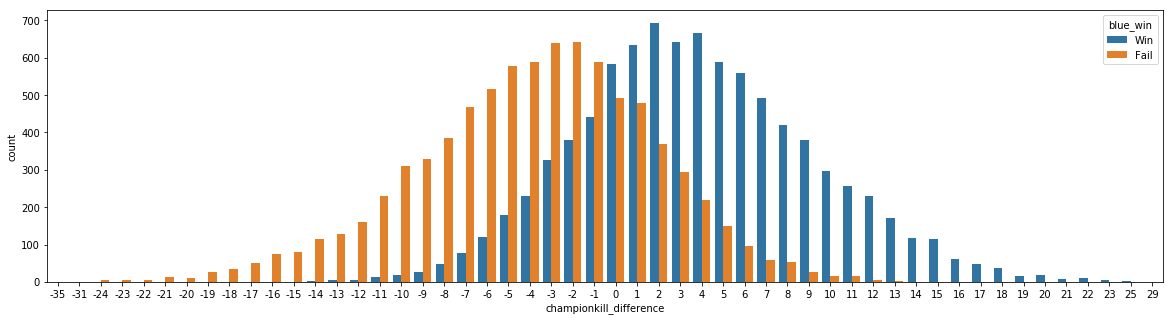

In [49]:
#Let us analyze how the dragon difference affects the outcome
plt.figure(figsize = (20, 5))
sns.countplot(x = 'championkill_difference', hue = 'blue_win', data = cleanse_df)
plt.show()

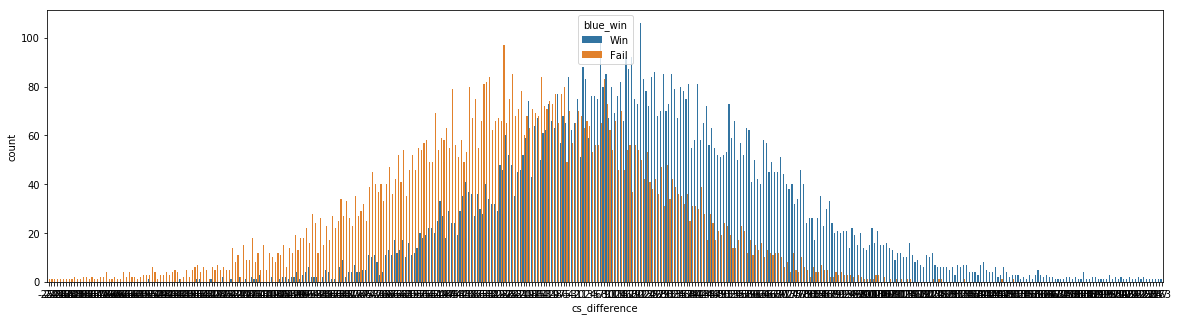

In [50]:
#Let us analyze how the dragon difference affects the outcome
plt.figure(figsize = (20, 5))
sns.countplot(x = 'cs_difference', hue = 'blue_win', data = cleanse_df)
plt.show()

## 5) Model building

In [51]:
dF = cleanse_df[['blue_win', 'gold_difference', 'xp_difference', 'cs_difference', 'ward_difference','wardkill_difference',
                 'dragon_difference', 'herald_difference', 'championkill_difference', 'championassist_difference', 
                 'tower_difference', 'inhibitor_difference']]
dF.head()

blue_win  gold_difference  xp_difference  cs_difference  ward_difference  \
0      Win             7297           4029             44                3   
1      Win             1610          -1685            -46               16   
2     Fail            -4057          -3256             38               -4   
3     Fail            -6645          -5184             18                2   
4      Win             -513            584             79                5   

   wardkill_difference  dragon_difference  herald_difference  \
0                  -11                  1                  0   
1                  -16                 -2                  1   
2                    1                  1                  0   
3                  -24                  0                  0   
4                    5                  0                  0   

   championkill_difference  championassist_difference  tower_difference  \
0                        3                          3                 3   
1                        1                          6                 1   
2                      -14                        -18                 0   
3                      -10                        -10                -3   
4                        0                        -13                 0   

   inhibitor_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [52]:
def win_label(x):
    '''This function is used to convert blue_win to numerical values'''
    if x == 'Win':
        return 1
    else:
        return 0

In [53]:
dF['blue_win'] = dF['blue_win'].transform(win_label)
dF.head()

C:\Users\cck3\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


blue_win  gold_difference  xp_difference  cs_difference  ward_difference  \
0         1             7297           4029             44                3   
1         1             1610          -1685            -46               16   
2         0            -4057          -3256             38               -4   
3         0            -6645          -5184             18                2   
4         1             -513            584             79                5   

   wardkill_difference  dragon_difference  herald_difference  \
0                  -11                  1                  0   
1                  -16                 -2                  1   
2                    1                  1                  0   
3                  -24                  0                  0   
4                    5                  0                  0   

   championkill_difference  championassist_difference  tower_difference  \
0                        3                          3                 3   
1                        1                          6                 1   
2                      -14                        -18                 0   
3                      -10                        -10                -3   
4                        0                        -13                 0   

   inhibitor_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [54]:
dfX = dF.iloc[:, 1:]
dfY = dF.iloc[:, 0]
dfX.head()

gold_difference  xp_difference  cs_difference  ward_difference  \
0             7297           4029             44                3   
1             1610          -1685            -46               16   
2            -4057          -3256             38               -4   
3            -6645          -5184             18                2   
4             -513            584             79                5   

   wardkill_difference  dragon_difference  herald_difference  \
0                  -11                  1                  0   
1                  -16                 -2                  1   
2                    1                  1                  0   
3                  -24                  0                  0   
4                    5                  0                  0   

   championkill_difference  championassist_difference  tower_difference  \
0                        3                          3                 3   
1                        1                          6                 1   
2                      -14                        -18                 0   
3                      -10                        -10                -3   
4                        0                        -13                 0   

   inhibitor_difference  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [55]:
dfY.head()

0    1
1    1
2    0
3    0
4    1
Name: blue_win, dtype: int64

### Train_test_split

In [56]:
dfX_train, dfX_test, dfY_train, dfY_test = train_test_split(dfX, dfY, test_size = 0.2, random_state = 0)

In [57]:
dfX_train.shape

(13740, 11)

In [58]:
dfY_train.shape

(13740,)

### Logistic Regression Optimization

In [59]:
def lr_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize Logistic Regression parameters using GridSearchCV from Scikit-learn'''
    model_lr = LogisticRegression()
    parameters = {'penalty': ['l1','l2'], 'C': [0.01, 0.1, 1, 10,100]}
    
    gs = GridSearchCV(estimator = model_lr, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [60]:
gs = lr_optimizer_estimator(dfX_train, dfY_train)

Wall time: 4.75 s


In [61]:
print(gs.best_score_)
print(gs.best_params_)

0.786171761281
{'C': 0.1, 'penalty': 'l1'}


### Logistic Regression Optimized Hyperparameter Analysis

In [62]:
model_lr = LogisticRegression(penalty = 'l1', C = 0.1)
model_lr.fit(dfX_train, dfY_train)

y_pred_train = model_lr.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_lr.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_lr.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [63]:
print('Logistic Regression -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

Logistic Regression -----> Training accuracy: 0.787191,  Test accuracy: 0.782887,  log_loos:  0.451513


In [64]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77      1650
          1       0.79      0.80      0.79      1786

avg / total       0.78      0.78      0.78      3436



In [128]:
model_lr.coef_

array([[  4.86729285e-04,   1.92763097e-04,  -4.42870601e-03,
          2.15331501e-04,   1.07620089e-02,   2.36753696e-01,
         -6.88357557e-02,  -3.51334070e-02,  -1.62042840e-02,
         -2.06078189e-01,   0.00000000e+00]])

#### For cs, champkill, champassist I can understand how these are probably not large contributors so whether they are positive or negative is not that big of a deal, but I expected tower to have positive coefficient which was a bit counter intuitive.. hmm...

### Random Forest Optimization

In [65]:
def forest_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the random forest parameters using GridSearchCV from Scikit-learn'''
    model_forest = RandomForestClassifier(n_jobs = 3)
    parameters = {'max_depth': [3, 4, 5, 10, 15], 'n_estimators': [100, 300, 500]}
    
    gs = GridSearchCV(estimator = model_forest, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = 3)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [66]:
%%time
gs_estimator = forest_optimizer_estimator(dfX_train, dfY_train)

Wall time: 1min 1s
Wall time: 1min 1s


In [67]:
print(gs_estimator.best_score_)
print(gs_estimator.best_params_)

0.784279475983
{'max_depth': 4, 'n_estimators': 500}


### Random Forest Optimized Hyperparameter Analysis

In [68]:
model_forest = RandomForestClassifier(max_depth = 4, n_estimators = 500, n_jobs = 3)
model_forest.fit(dfX_train, dfY_train)

y_pred_train = model_forest.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_forest.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_forest.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [69]:
print('RandomForest -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

RandomForest -----> Training accuracy: 0.786608,  Test accuracy: 0.773865,  log_loos:  0.463821


In [70]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.77      0.76      0.76      1650
          1       0.78      0.78      0.78      1786

avg / total       0.77      0.77      0.77      3436



## XGBoost Model Optimization

In [71]:
def xgboost_optimizer_estimator(dfX, dfY):
    '''This function is used to optimize the xgboost parameters using GridSearchCV from Scikit-learn'''
    model_xgb = xgboost.XGBClassifier(nthread = -1)
    parameters = {'max_depth': [2, 3, 4, 5, 6], 'n_estimators': [100, 300, 500]}
    
    gs = GridSearchCV(estimator = model_xgb, param_grid = parameters, scoring = 'accuracy', cv = 4, n_jobs = -1)
    %time gs = gs.fit(dfX, dfY)
    return gs

In [72]:
%%time
gs_estimator = xgboost_optimizer_estimator(dfX_train, dfY_train)

Wall time: 44.2 s
Wall time: 44.2 s


In [73]:
print(gs_estimator.best_score_)
print(gs_estimator.best_params_)

0.784352256186
{'max_depth': 2, 'n_estimators': 100}


### XGBoost Optimized Hyperparameter Analysis

In [74]:
model_xgb = xgboost.XGBClassifier(max_depth = 2, n_estimators = 100, nthread = -1)
model_xgb.fit(dfX_train, dfY_train)

y_pred_train = model_xgb.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_xgb.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_xgb.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [75]:
print('XGBoost -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

XGBoost -----> Training accuracy: 0.788501,  Test accuracy: 0.773865,  log_loos:  0.457043


In [76]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.77      0.75      0.76      1650
          1       0.78      0.79      0.78      1786

avg / total       0.77      0.77      0.77      3436



### AdaBoost Model Analysis

In [102]:
model_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2, random_state=0), 
                               algorithm="SAMME.R", n_estimators=100)
model_ada.fit(dfX_train, dfY_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [103]:
y_pred_train = model_ada.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_ada.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_ada.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [104]:
print('Adaboost -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

Adaboost -----> Training accuracy: 0.795633,  Test accuracy: 0.771246,  log_loos:  0.640451


In [105]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.77      0.75      0.76      1650
          1       0.77      0.79      0.78      1786

avg / total       0.77      0.77      0.77      3436



### BaggingClassifier Analysis

In [86]:
model_bag = BaggingClassifier(DecisionTreeClassifier(), bootstrap_features=True, random_state=0)
model_bag.fit(dfX_train, dfY_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=True, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

In [106]:
y_pred_train = model_bag.predict(dfX_train)
train_accuracy = accuracy_score(dfY_train, y_pred_train)

y_pred_test = model_bag.predict(dfX_test)
test_accuracy = accuracy_score(dfY_test, y_pred_test)

y_proba = model_bag.predict_proba(dfX_test)
performance = log_loss(dfY_test, y_proba)

In [107]:
print('Bagging -----> Training accuracy: %f,  Test accuracy: %f,  log_loos:  %f' % (train_accuracy, test_accuracy, performance))

Bagging -----> Training accuracy: 0.987191,  Test accuracy: 0.747672,  log_loos:  0.991875


In [108]:
print(classification_report(dfY_test, y_pred_test))

             precision    recall  f1-score   support

          0       0.72      0.78      0.75      1650
          1       0.78      0.72      0.75      1786

avg / total       0.75      0.75      0.75      3436



### Summary

Overall, all the models except bagging classifier performed similarly except Logistic Regression did slightly better than the others. This indicates the data was simple enough that using more complex model actually hurt the result; at least that is my take on it.

As for the coefficients, I was a bit thrown off by the negative coefficient associated with tower, champkill, champassist and cs. Obviously, there are more to these variables than what meets the eye.

For serialization and flask implementation, I will use the Logistic Regression model because it not only has the best result, but also light model.

### Feature Importance

 1 gold_difference                0.250647
 2 xp_difference                  0.197305
 3 championkill_difference        0.115750
 4 cs_difference                  0.102141
 5 championassist_difference      0.094575
 6 ward_difference                0.069512
 7 tower_difference               0.065729
 8 wardkill_difference            0.060819
 9 dragon_difference              0.027003
10 herald_difference              0.016288
11 inhibitor_difference           0.000231


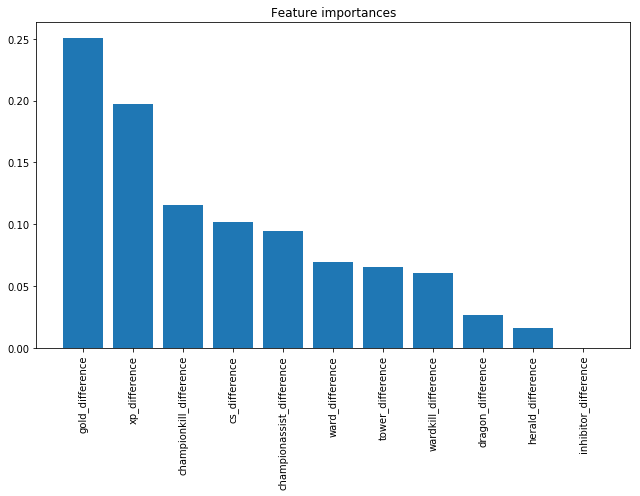

In [113]:
'''Feature importance analysis code'''
'''Reference: Python Machine Learning'''
feat_labels = np.array(dfX.columns)
forest = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs = 3)
forest.fit(dfX_train, dfY_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:11]

for f in range(len(indices)):
    print("%2d %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]] ))

plt.figure(figsize = (9, 7))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), feat_labels[indices], rotation=90)
plt.tight_layout()
plt.show()

## 6) Model Serialization and Setting up a Simple Flask implementation

In [2]:
import requests, json
import pickle

from flask import Flask, abort, jsonify, request

### Since Logistic Regression had the best accuracy, I'll use it for serialization. It's also the simplest and takes least storage space

In [135]:
pickle.dump(model_lr, open('league_lr.pkl', 'wb'))

### Let us check the model is properly saved

In [118]:
logistic_model = pickle.load(open('league_lr.pkl', 'rb'))

In [119]:
print(classification_report(dfY_test, logistic_model.predict(dfX_test)))

             precision    recall  f1-score   support

          0       0.78      0.76      0.77      1650
          1       0.79      0.80      0.79      1786

avg / total       0.78      0.78      0.78      3436



#### What I want to do ultimately is to predict the winning probability. So, instead of predict, I want to use predict_proba.

In [120]:
x_data = np.array([3000, 2500, 2, 10, -1, 5, 2, 2, 2, 0, 0])
x_data = x_data.reshape(1, 11)
result = logistic_model.predict(x_data)
result_proba = logistic_model.predict_proba(x_data)
print(result)
print(result_proba)
print(result_proba[0][1])

[1]
[[ 0.05108374  0.94891626]]
0.94891626492


### Flask script -> The actual script is run on a separate IDE, but the code is shown here for demonstration purposes

In [ ]:
app = Flask(__name__)

league_logistic = pickle.load(open('league_lr.pkl', 'rb'))

@app.route('/league', methods = ['POST'])
def make_predict():
    #get_json parses the incoming JSON request data and returns it.
    data = request.get_json(force=True)
    #The data that is stored inside 'data' is a dictionary. Now you want to
    #take each element and put it into a list
    predict_request = [data['gold'], data['xp'], data['cs'], data['ward'], data['wardkill'], data['dragon'],
                       data['herald'], data['champkill'], data['champassist'], data['tower'], data['inhibitor']]
    resize_shape = len(predict_request)
    #ML algorithms take np.array of specific size, so the following two lines
    #achieve that.
    predict_request = np.array(predict_request)
    predict_request = predict_request.reshape(1, resize_shape)
    
    #You want to return the probability of winning chance
    y_hat = league_logistic.predict_proba(predict_request)
    y_hat = y_hat[0][1]
    '''There is some issue turning np.array object to json object. Use .tolist() method for that
    Reference: https://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable'''
    output = y_hat.tolist()
    '''From what I can understand, jsonify() method converts the result into a dictionary form
    results : output'''
    return jsonify(results = output)


if __name__ == '__main__':
    app.run(host='127.0.0.1', port='8080')

### Flask server request

In [ ]:
url = 'http://ckang9000.pythonanywhere.com/league'
data = json.dumps({'gold' : 2500, 'xp' : 1500, 'cs' : -50, 'ward' : 10, 'wardkill' : 5, 'dragon' : 1,
                   'herald' : 0, 'champkill' : 4, 'champassist' : 8, 'tower' : 1, 'inhibitor' : 0})
r = requests.post(url, data)

'''Without the .json(), the result I get shows the response status such as 200, 400. To read the actual
json data, I must specify .json()'''
print(r.json())